## **Importing libraries and storing API keys**

In [9]:
from google.colab import drive
drive.mount('/content/drive/')
from google.colab import files
src = list(files.upload().values())[0]
open('backtesting.py','wb').write(src)
import backtesting as bt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests 
import datetime



Mounted at /content/drive/


Saving backtesting.py to backtesting.py


In [10]:
API_KEY = 'DEE65DARSUB6S9JY'

# **Acquiring data**

In [11]:
symbol = 'RELIANCE.BSE'
r = requests.get(f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=RELIANCE.BSE&outputsize=full&apikey=demo').json()

In [12]:
#Data Cleaning
metadata = r['Meta Data']
df = pd.DataFrame(r['Time Series (Daily)'], dtype=float).transpose()

#Reverse index
df = df.reindex(index=df.index[::-1])
df.reset_index(level=0, inplace=True)

#Rename cols
df = df.rename({
    'index': 'date',
    '1. open': 'open',
    '2. high': 'high',
    '3. low': 'low',
    '4. close': 'close',
    '5. adjusted close': 'adjusted_close',
    '6. volume': 'volume',
    '7. dividend amount': 'dividend_amount',
    '8. split coefficient': 'split_coefficient'
},axis=1)

#Convert date col to datetime format
df['date'] = pd.to_datetime(df['date'])

In [13]:
df = df[((df['date'] >= pd.to_datetime('2020-01-01')) & (df['date'] <= pd.to_datetime('2022-06-01')))]

# **Calculating moving averages**


In [14]:
#Short moving averages (5-20 periods) are best suited for short-term trends and trading
df['ma_200'] = df['close'].rolling(200).mean()

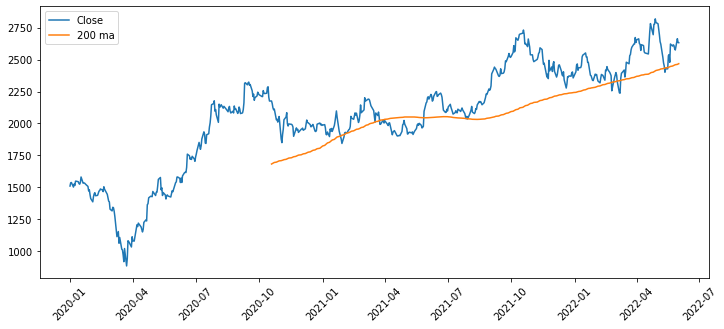

In [15]:
#plot for validation
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)

plt.plot(df['date'], df['close'], label = 'Close')
plt.plot(df['date'], df['ma_200'], label = '200 ma')

plt.legend()
plt.show()

# **Calculating bollinger bands with the help of moving average and 2σ standard deviation**


In [16]:
period = 20

#Calculate 20-ma and std dev
df['ma_20'] = df['close'].rolling(period).mean()
df['std'] = df['close'].rolling(period).std()

#Calculate bollinger bands using std dev
df['upper_bollinger'] = df['ma_20'] + (2 * df['std'])
df['lower_bollinger'] = df['ma_20'] - (2 * df['std'])

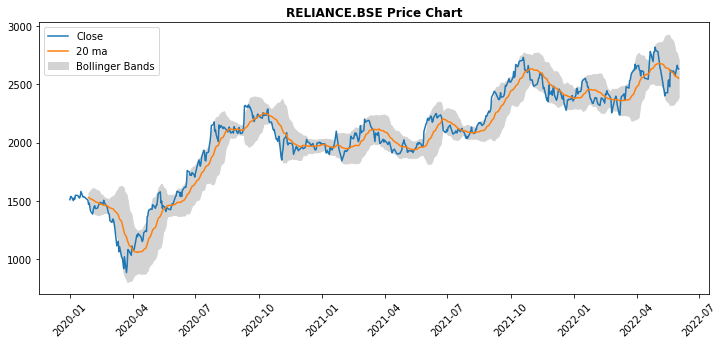

In [24]:
#plot for validation
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)

x_axis = df['date']

plt.plot(x_axis, df['close'], label = 'Close')
plt.plot(df['date'], df['ma_20'], label = '20 ma')
plt.fill_between(x_axis, df['upper_bollinger'], df['lower_bollinger'], label = 'Bollinger Bands', color='lightgrey')

plt.title('RELIANCE.BSE Price Chart', fontweight="bold")
plt.legend()
plt.show()

# **Calculating Relative Strength Index**

In [17]:
def gain(value):
    if value < 0:
        return 0
    else:
        return value

In [18]:
def loss(value):
    if value > 0:
        return 0
    else:
        return abs(value)

In [19]:
period = 6

#Calculate price delta
df['delta'] = df['close'].diff()

#Classify delta into gain & loss
df['gain'] = df['delta'].apply(lambda x:gain(x))
df['loss'] = df['delta'].apply(lambda x:loss(x))

#Calculate ema 
df['ema_gain'] = df['gain'].ewm(period).mean()
df['ema_loss'] = df['loss'].ewm(period).mean()

#Calculate RSI
df['rs'] = df['ema_gain']/df['ema_loss']
df['rsi'] = df['rs'].apply(lambda x: 100 - (100/(x+1)))

(0.0, 100.0)

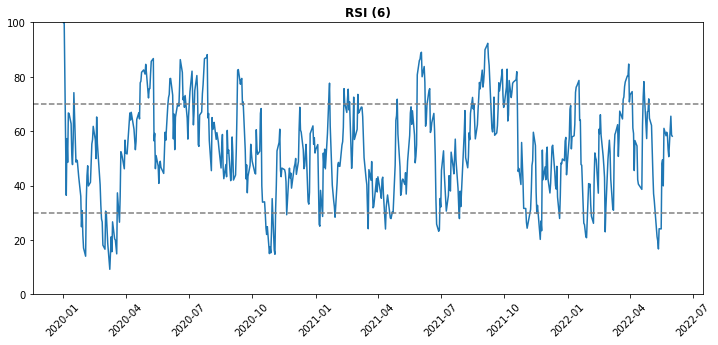

In [20]:
#plot for validation
plt.figure(figsize=(12,5))
plt.xticks(rotation=45)

x_axis = df['date']

plt.plot(x_axis, df['rsi'])
plt.axhline(30, c= (.5,.5,.5), ls='--')
plt.axhline(70, c= (.5,.5,.5), ls='--')

plt.title('RSI (6)', fontweight="bold")
plt.ylim([0, 100])

# **Deciding on whether to buy or sell**
### Criterion : 
##### 1. If price is below bollinger band and 10-period RSI is below 30, then BUY
##### 2. If price is above bollinger band and 10-period RSI is above 70, then SELL 


In [21]:
#buy signal
df['signal'] = np.where(
    (df['rsi'] < 30) &
    (df['close'] < df['lower_bollinger']), 1, np.nan)

#sell signal
df['signal'] = np.where(
    (df['rsi'] > 70) & 
    (df['close'] > df['upper_bollinger']), -1, df['signal'])

#buy/sell next trading day
df['signal'] = df['signal'].shift()
df['signal'] = df['signal'].fillna(0)

# **Backtesting** 

In [26]:
bt.backtest_dataframe(df)


Buying at 1479.6996 on 2020-01-29 00:00:00
Selling at 1371.4996 on 2020-04-23 00:00:00
Buying at 2107.1 on 2020-10-22 00:00:00
Selling at 2097.85 on 2021-01-21 00:00:00
Buying at 1931.9 on 2021-04-13 00:00:00
Selling at 2160.45 on 2021-05-31 00:00:00
Buying at 2086.0 on 2021-06-28 00:00:00
Selling at 2163.95 on 2021-08-17 00:00:00
Buying at 2386.15 on 2021-11-23 00:00:00
Selling at 2535.35 on 2022-01-13 00:00:00
Buying at 2283.95 on 2022-02-25 00:00:00
Selling at 2539.7 on 2022-03-23 00:00:00

Evaluation Metrics:
-----------------------------------
Number of Trades: 6
Number of Gains: 4
Number of Losses: 2
Total Returns: 26.49%
Win Rate: 66.67%
Average Gain: 8.25%
Average Loss: -3.88%
Max Return: 11.83%
Max Loss: -7.31%

